In [1]:
import os
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
print(notebook_dir)

/home/jetson/cmap/athirdmapper


[  0 100 101]


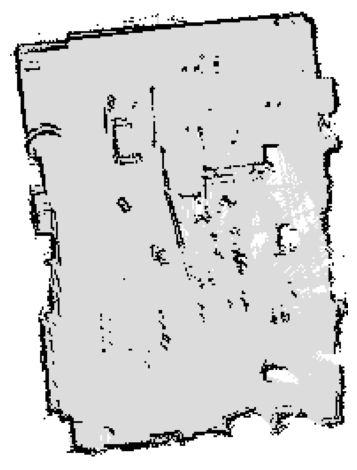

In [2]:
import cv2
import yaml
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
os.chdir(notebook_dir)
os.chdir('./exp0610_ViT-B-16-SigLIP_3_copy')
map_img = cv2.imread('map.pgm', cv2.IMREAD_GRAYSCALE)
with open('map.yaml', 'r') as file:
    map_data = yaml.safe_load(file)

print(np.unique(map_img))
_map = np.copy(map_img)
_map[_map == 101] = 255
_map[_map == 100] = 220
plt.imshow(np.flip(_map, 0), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
# 101 = unknown space
# 0 = occupied space
# 100 = free space => 255

In [3]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
def similarity(image_features, text_features):
    if isinstance(image_features, list): image_features = np.array(image_features)
    if isinstance(text_features, list): text_features = np.array(text_features)
    try: 
        if torch.cuda.is_available(): 
            return image_features @ text_features.cpu().numpy().T
    except: return np.dot(image_features, text_features.T)
def show_images(ind, text='candidates'):
    for i, img_ind in enumerate(ind):
        r = len(ind)//7+1
        plt.figure(text, figsize=(9, r*2))
        plt.subplot(r, 7, i+1)
        img = cv2.imread('n_images/' + str(img_ind) + '.png')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
    plt.savefig(f'{text}_cdd.png')
    plt.show()
def point2pixel(point, origin, resolution):
    return (int((point[0] - origin[0]) / resolution),
            int((point[1] - origin[1]) / resolution))
def probmap(conf, map, map_data, grid_size, mode='freq', show=True):
    d = 0 if mode == 'score' else 1
    origin = map_data['origin']
    resolution = map_data['resolution']
    grid_pixel = int(grid_size / resolution // 2)
    ret = np.copy(map)
    ret = cv2.cvtColor(ret, cv2.COLOR_GRAY2BGR)
    color = (0,0,255)
    if len(conf) == 0: return ret
    max_p = max(conf.values(), key=lambda x: x[d])[d]
    min_p = min(conf.values(), key=lambda x: x[d])[d]
    for point, score in conf.items():
        x, y = point2pixel(point, origin, resolution)
        try: p = (score[d]-min_p) / (max_p-min_p)
        except ZeroDivisionError: p = 1
        layer = np.copy(ret)
        layer = cv2.rectangle(layer, (x-grid_pixel,y-grid_pixel), (x+grid_pixel,y+grid_pixel), color, -1)
        ret = cv2.addWeighted(ret, 1-p, layer, p, 0)
    return ret
def get_conf(features, voxels, text_feature, th=0.01, show_candidates=False, text='candidates'):
    similarities = similarity(features, text_feature).squeeze()*100
    softmax = F.softmax(torch.tensor(similarities), dim=0).numpy()
    m = np.sum(softmax > th)
    sim_sort_ind = np.argsort(similarities, axis=0)[::-1][:m]
    conf = {}
    for index in sim_sort_ind:
        # score = similarities[index]
        score = softmax[index]
        for point in voxels[index]:
            [s, n] = conf.get(tuple(point), [0,0])
            conf[tuple(point)] = [(s * n + score) / (n + 1), n + 1]
    print(f'{m} frames detected')
    print(sim_sort_ind)
    print(f'{len(conf)} grid points are detected')
    print('conf:', conf)
    if show_candidates: show_images(sim_sort_ind, text=text)
    # sort confidence by value
    # conf_score = dict(sorted(conf.items(), key=lambda item: item[1], reverse=True))
    # conf_freq = dict(sorted(conf.items(), key=lambda item: item[1][1], reverse=True))
    # k_s = list(conf_score.keys())
    # v_s = list(conf_score.values())
    # k_f = list(conf_freq.keys())
    # v_f = list(conf_freq.values())
    return conf

['boxes', 'fire extinguisher', 'luggage', 'a single traffic cone', 'pile of traffic cones', 'trash bin', 'umbrella', 'trolley', 'chair', 'folded chair']
boxes
22 frames detected
[1312  663 1315 1370 1337 1163 1300 1325 1228 1309 1328 1340 1151 1081
 1157 1154 1303 1148 1306 1373 1227 1318]
31 grid points are detected
conf: {(0.75, -8.25, 0.0): [0.01692968304253427, 8], (1.0, -8.25, 0.0): [0.016134047422827185, 10], (1.5, -8.5, 0.0): [0.01602345635469968, 11], (1.75, -8.75, 0.0): [0.01661248776764656, 10], (1.75, -8.5, 0.0): [0.01602345635469968, 11], (-5.25, -1.25, 0.0): [0.03205015418855267, 1], (-5.25, -1.0, 0.0): [0.03205015418855267, 1], (-5.0, -1.75, 0.0): [0.03205015418855267, 1], (-5.0, -1.5, 0.0): [0.03205015418855267, 1], (-5.0, -1.25, 0.0): [0.03205015418855267, 1], (-5.0, -1.0, 0.0): [0.03205015418855267, 1], (-4.5, -0.25, 0.0): [0.03205015418855267, 1], (-0.25, -8.75, 0.0): [0.013754479345671554, 2], (0.0, -8.75, 0.0): [0.012594282443925695, 3], (0.25, -9.0, 0.0): [0.013754

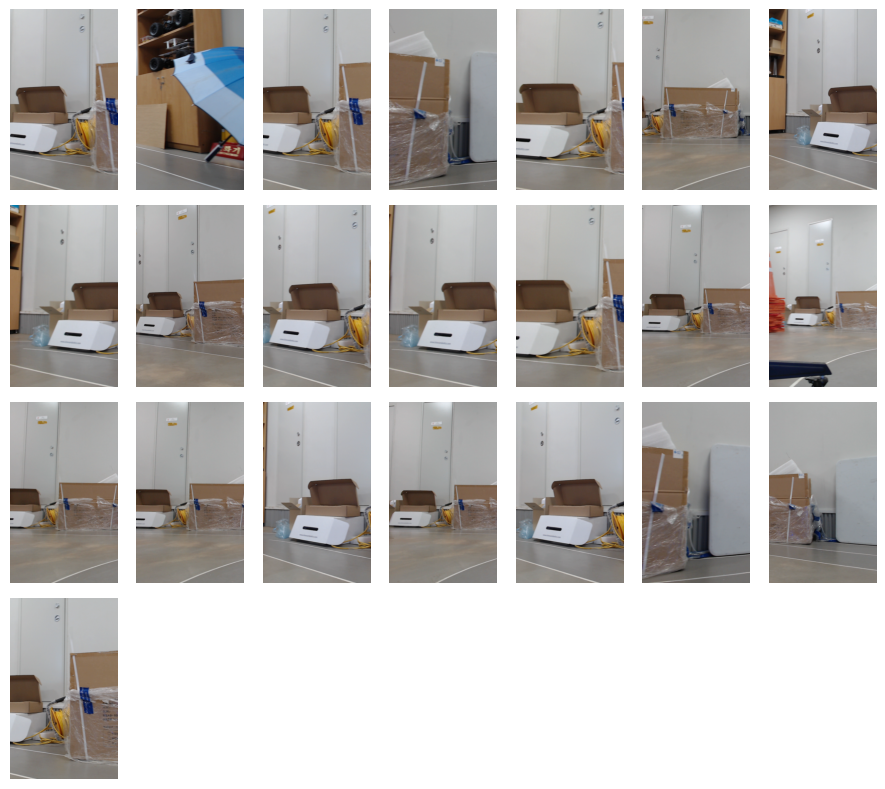

fire extinguisher
28 frames detected
[ 554  551  560  548  563  545  557  566  578  572  542  569  575  533
  527  524 2211 2217 2214 2220  494  515  509  539  518 2223  530  581]
16 grid points are detected
conf: {(-3.25, 0.0, 0.0): [0.035762018855442654, 18], (-3.25, 0.25, 0.0): [0.03145451036937449, 23], (-3.0, 0.5, 0.0): [0.030832207177773515, 26], (-3.0, 0.75, 0.0): [0.03501403540446887, 21], (-3.25, -0.25, 0.0): [0.03372548214904612, 8], (-3.0, -0.25, 0.0): [0.01913755386087792, 9], (-3.0, 0.0, 0.0): [0.02004214975472406, 8], (-3.0, 0.25, 0.0): [0.01711993182826452, 14], (-4.5, -0.25, 0.0): [0.026208625505997427, 6], (-4.75, -0.25, 0.0): [0.024207871141969903, 4], (-2.75, -0.25, 0.0): [0.020076613029946084, 2], (-2.75, 0.0, 0.0): [0.016205225119439167, 2], (-2.25, 0.5, 0.0): [0.014407862366123514, 4], (-1.75, 0.75, 0.0): [0.015648906560948677, 3], (-2.5, 0.5, 0.0): [0.012364819792023063, 1], (-1.75, 1.0, 0.0): [0.011734951453917744, 1]}


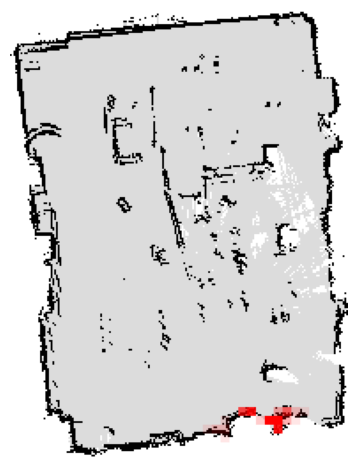

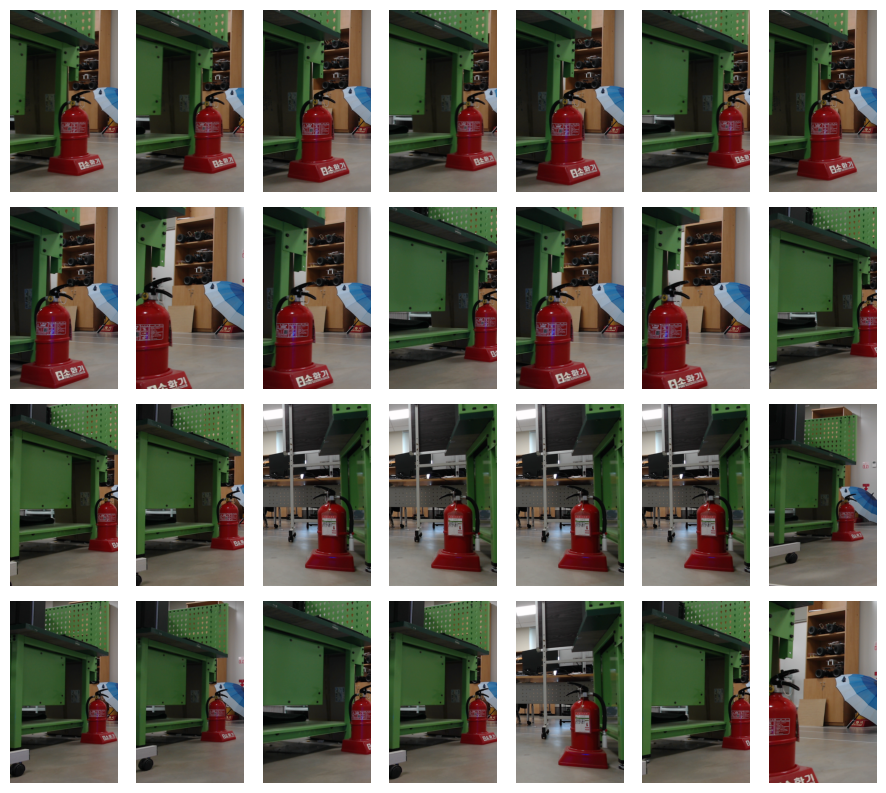

luggage
21 frames detected
[ 938  866  916  919  907  863  910  860  898  869  913  962  959 1807
  941  904 1822  845 1643 1694  953]
6 grid points are detected
conf: {(-1.75, -3.75, 0.0): [0.026548768511725173, 6], (-1.75, -3.5, 0.0): [0.03283061524814345, 12], (-1.75, -4.0, 0.0): [0.016647368279923146, 2], (-1.5, -4.0, 0.0): [0.014307924948881463, 1], (-1.5, -6.0, 0.0): [0.011430829807626311, 1], (-1.5, -5.75, 0.0): [0.011430829807626311, 1]}


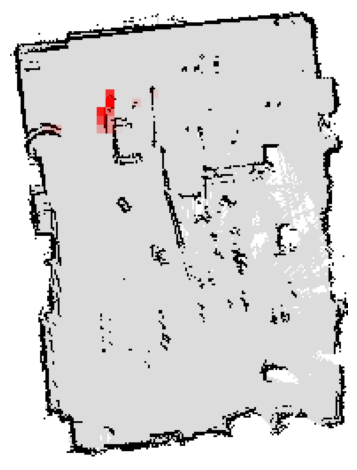

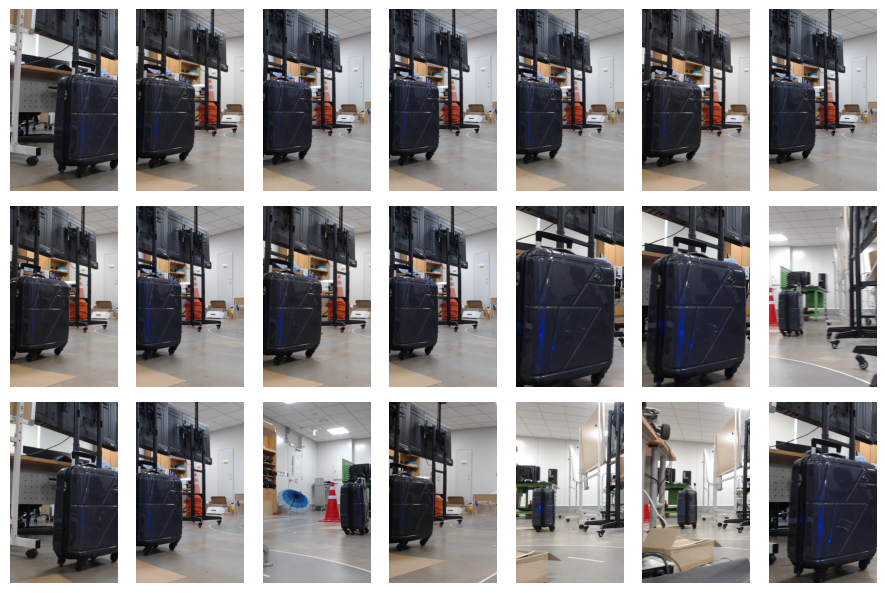

a single traffic cone
23 frames detected
[1094  785 1100  782  788 1268 1106  686 1097 1103 1283 1127  725  722
 1235  704  791  719 1238  734 1277 1941  707]
10 grid points are detected
conf: {(-0.5, -5.5, 0.0): [0.055510007954351605, 5], (-2.75, -2.25, 0.0): [0.03019806939969066, 11], (1.25, -7.25, 0.0): [0.028650401551261893, 4], (1.25, -7.0, 0.0): [0.023709869060670935, 6], (1.5, -7.0, 0.0): [0.02263319327223433, 5], (-2.5, -2.25, 0.0): [0.01416560159245747, 6], (1.5, -7.25, 0.0): [0.013828804079489006, 2], (1.5, -6.75, 0.0): [0.013828804079489006, 2], (-2.75, -2.5, 0.0): [0.010283991617472035, 1], (-2.5, -2.5, 0.0): [0.010283991617472035, 1]}


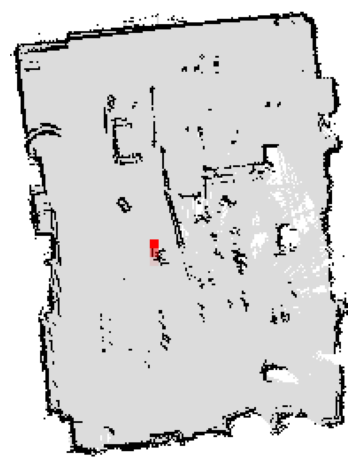

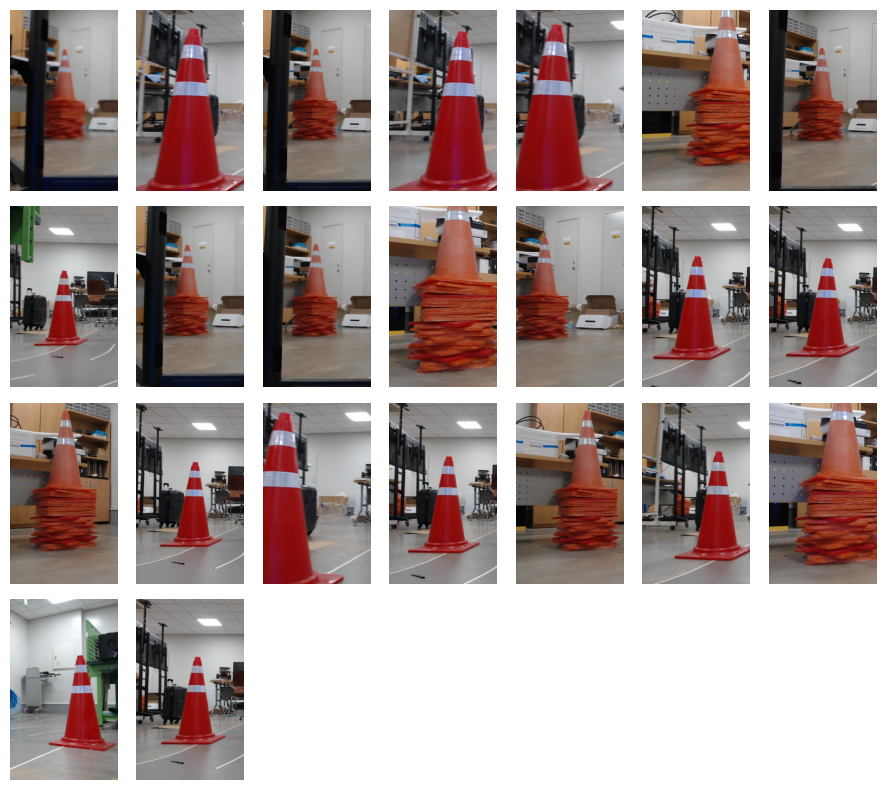

pile of traffic cones
23 frames detected
[1286 1277  788 1289 1283 1280 1088 1295 1094 1106 1268 1274 1100 1298
 1115 1292 1112 1097 1118 1109 1130 1127 1124]
7 grid points are detected
conf: {(1.25, -7.25, 0.0): [0.051412636356555096, 12], (1.25, -7.0, 0.0): [0.0589113814033103, 10], (1.5, -7.0, 0.0): [0.06890745223880898, 8], (-2.75, -2.25, 0.0): [0.09488513029969846, 1], (-0.5, -5.5, 0.0): [0.021609540448571385, 5], (1.5, -7.5, 0.0): [0.01888433610117086, 3], (1.5, -7.25, 0.0): [0.01888433610117086, 3]}


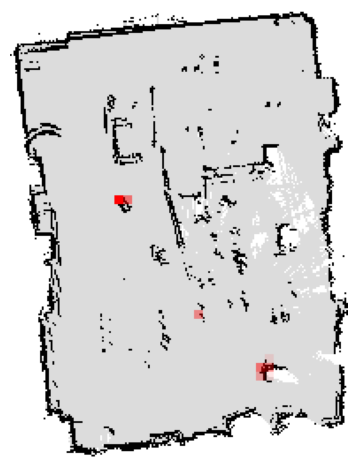

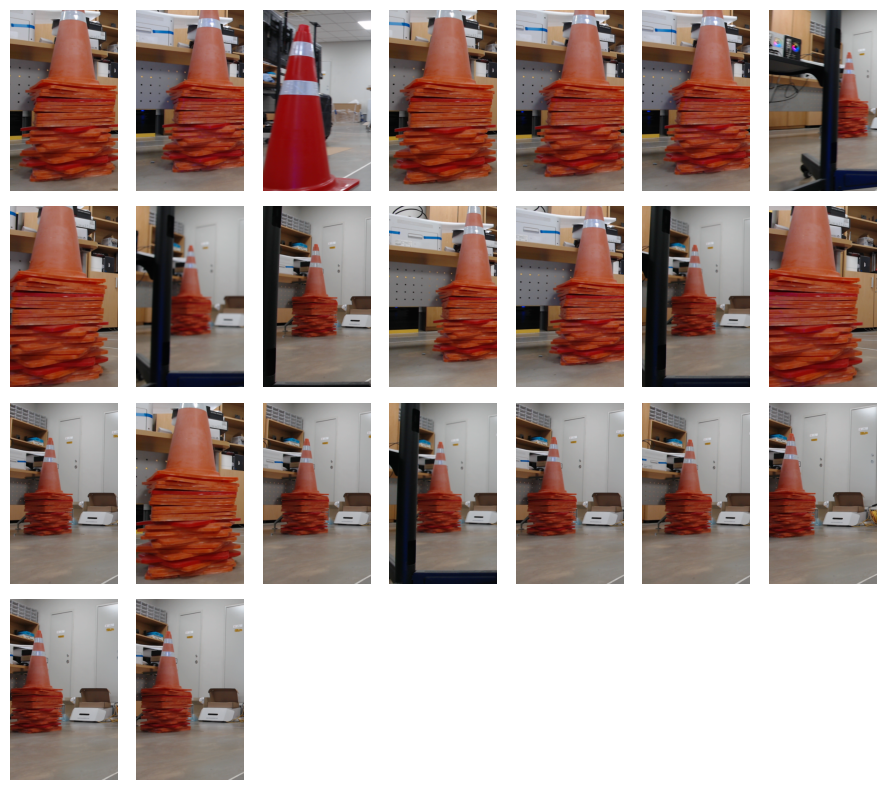

trash bin
24 frames detected
[1475 1447 1481 1386 1478 1450 1429 1487 1426 1417 1432 1414 1389 1444
 1484 1423 1438 1435 1472 1408 1405 1441 1380 1420]
11 grid points are detected
conf: {(-3.25, -9.25, 0.0): [0.05136704663657074, 3], (-3.0, -9.25, 0.0): [0.057550271387071056, 2], (-3.0, -8.75, 0.0): [0.04387166240125381, 9], (-3.0, -9.0, 0.0): [0.08570560697367205, 1], (-2.5, -9.0, 0.0): [0.023777732631374445, 2], (-3.0, -8.5, 0.0): [0.021439918745568713, 1], (-2.75, -9.25, 0.0): [0.015397491783854243, 3], (-2.5, -9.25, 0.0): [0.016312164843839887, 3], (-2.25, -9.25, 0.0): [0.018514236507615404, 1], (-2.25, -9.0, 0.0): [0.018058495301475463, 1], (-2.0, -8.75, 0.0): [0.013133565662328837, 1]}


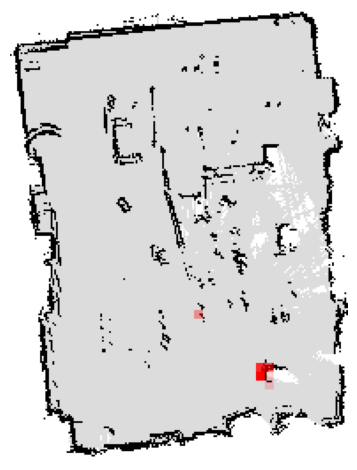

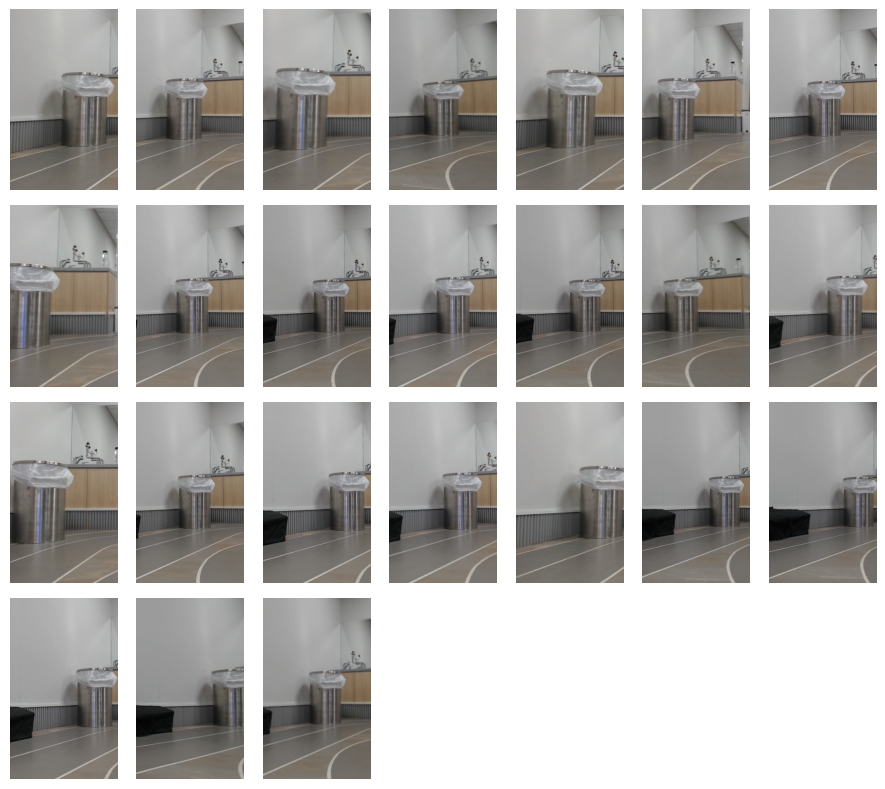

umbrella
33 frames detected
[ 648  651  642  616  625  619  645  654  622  657  639 2033 2011 2008
 2005 2045 2030 2039 2021 2002 1999  628 2042 2054 2027  613 2036  636
 2048 2051 1996  544  610]
21 grid points are detected
conf: {(-5.5, -0.5, 0.0): [0.025107954797128993, 11], (-5.5, -0.25, 0.0): [0.025824105884632697, 10], (-5.25, -1.25, 0.0): [0.03395995658221594, 4], (-5.0, -1.25, 0.0): [0.027642795840981418, 11], (-5.0, -0.25, 0.0): [0.022041853407206696, 23], (-4.75, -0.25, 0.0): [0.02216610948078445, 26], (-4.5, -0.25, 0.0): [0.022930776752060313, 25], (-5.25, -0.5, 0.0): [0.021510657917021753, 17], (-5.25, -0.25, 0.0): [0.026092700931603718, 4], (-5.5, 0.0, 0.0): [0.01901204300392613, 5], (-5.0, -1.5, 0.0): [0.02535935883704768, 3], (-4.5, -0.5, 0.0): [0.017642181768021323, 10], (-4.25, -0.25, 0.0): [0.02142004346302878, 4], (-5.25, -0.75, 0.0): [0.017344785372809965, 4], (-5.0, -0.5, 0.0): [0.016577911935611436, 7], (-5.5, -0.75, 0.0): [0.01642277081491467, 2], (-5.0, -1.0, 0.

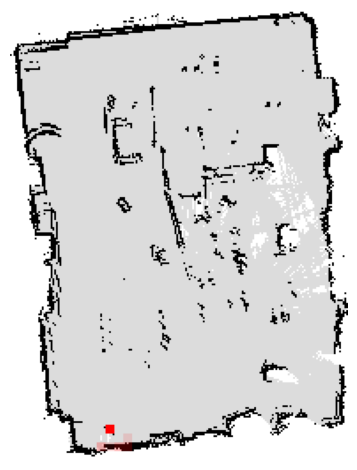

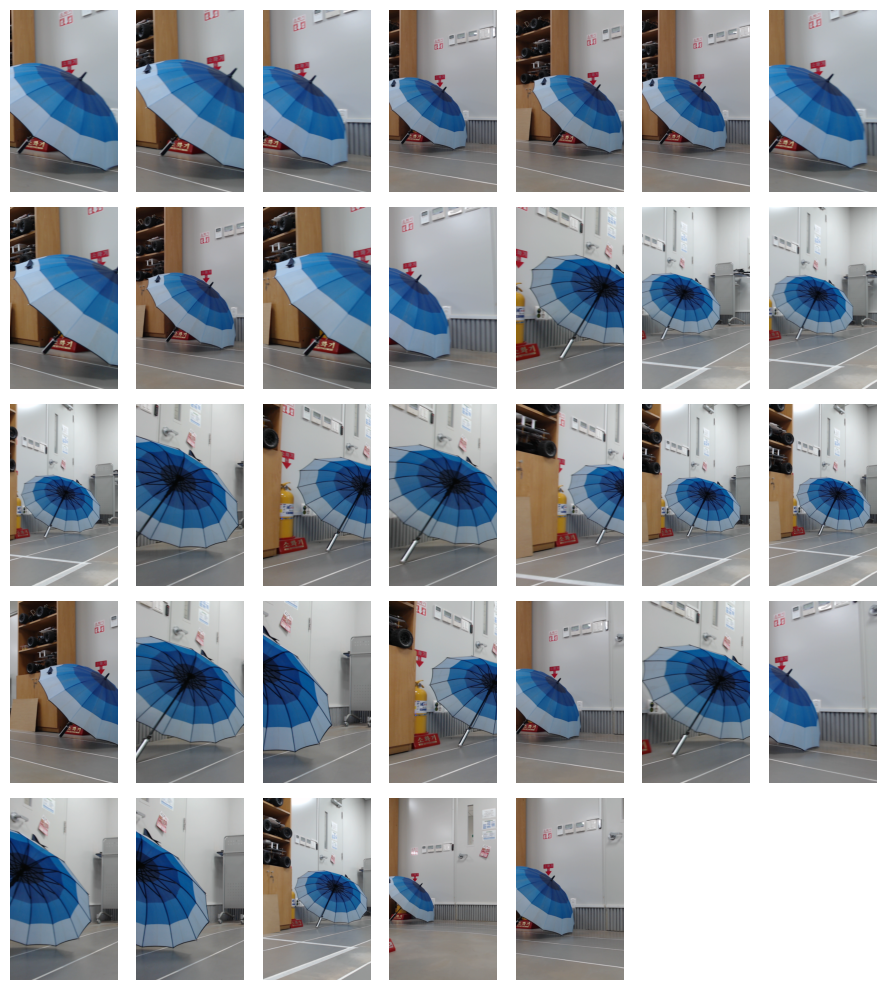

trolley
15 frames detected
[1982 1979  684 1967 1991  687  661  693  690 1976 1970 2629  699  652
 1973]
24 grid points are detected
conf: {(-5.25, -2.75, 0.0): [0.020140899923546413, 4], (-5.25, -2.5, 0.0): [0.018483177367115005, 7], (-5.25, -2.25, 0.0): [0.024148052628014387, 2], (-5.25, -2.0, 0.0): [0.024148052628014387, 2], (-5.0, -3.0, 0.0): [0.018862198905137934, 5], (-5.0, -2.75, 0.0): [0.01760156206819088, 6], (-5.0, -2.5, 0.0): [0.016643827611573313, 8], (-5.0, -2.0, 0.0): [0.018132230774096075, 7], (-4.75, -2.5, 0.0): [0.01678773968691581, 11], (-4.75, -2.0, 0.0): [0.018433669980777844, 4], (-4.5, -2.5, 0.0): [0.019033562510484325, 5], (-5.25, -3.0, 0.0): [0.021776551096417858, 1], (-5.0, -1.75, 0.0): [0.01520983396062001, 7], (-5.0, -1.5, 0.0): [0.015571210893972988, 4], (-4.75, -3.5, 0.0): [0.014997174317864329, 2], (-4.75, -3.25, 0.0): [0.014997174317864329, 2], (-4.75, -2.75, 0.0): [0.013276218352557524, 4], (-4.5, -3.5, 0.0): [0.014997174317864329, 2], (-4.5, -3.25, 0.0)

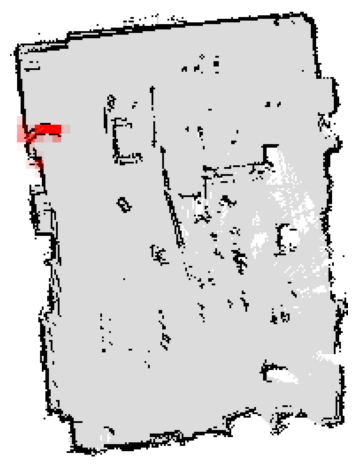

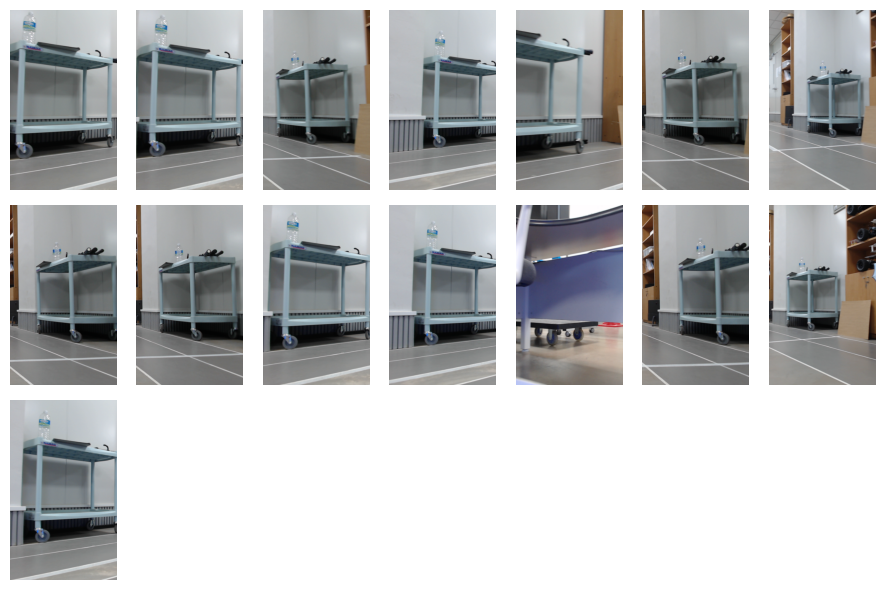

chair
4 frames detected
[ 861  864  858 1482]
7 grid points are detected
conf: {(-3.25, -5.5, 0.0): [0.01389659545203617, 3], (-3.0, -5.5, 0.0): [0.014312941558274847, 1], (-3.0, -6.5, 0.0): [0.01007444160517804, 1], (-3.0, -6.25, 0.0): [0.01007444160517804, 1], (-2.25, -6.75, 0.0): [0.01007444160517804, 1], (-2.25, -6.5, 0.0): [0.01007444160517804, 1], (-1.75, -7.0, 0.0): [0.01007444160517804, 1]}


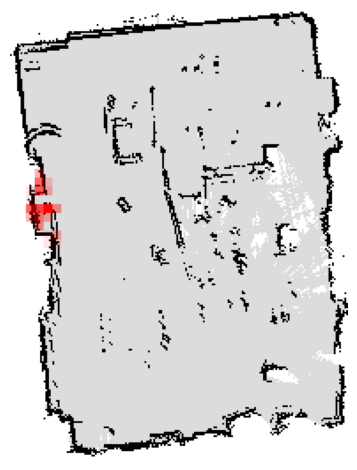

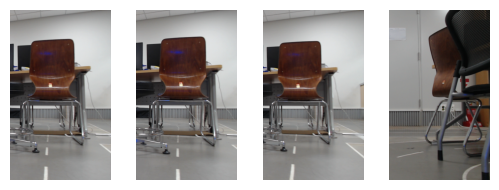

folded chair
15 frames detected
[2425 2868 1513 2422 2428 2419 2431 1485 2874 1544 1504 2434 2862  228
 1488]
24 grid points are detected
conf: {(1.5, 2.75, 0.0): [0.026168623158255383, 3], (1.75, 2.75, 0.0): [0.023388523820336616, 6], (1.75, 3.0, 0.0): [0.02339134809833189, 4], (-2.25, -6.25, 0.0): [0.02040839823154892, 2], (-1.75, -6.5, 0.0): [0.026913551256117725, 1], (1.5, 3.0, 0.0): [0.0248504075112658, 2], (2.25, 2.75, 0.0): [0.01788366333264472, 2], (-3.0, -6.5, 0.0): [0.017877269598769806, 1], (-3.0, -6.25, 0.0): [0.014195559122627257, 3], (-2.25, -6.75, 0.0): [0.014195559122627257, 3], (-2.25, -6.5, 0.0): [0.014341716080450826, 2], (-1.75, -7.0, 0.0): [0.014341716080450826, 2], (-1.25, -6.5, 0.0): [0.015253532438156919, 1], (-1.25, -6.25, 0.0): [0.015253532438156919, 1], (-1.25, -6.0, 0.0): [0.015253532438156919, 1], (-1.75, -6.75, 0.0): [0.013903245206980119, 1], (2.75, 2.0, 0.0): [0.012124458424721955, 1], (2.75, 2.25, 0.0): [0.012124458424721955, 1], (2.75, 2.5, 0.0): [0.01

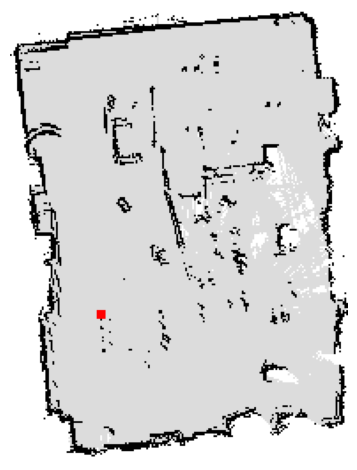

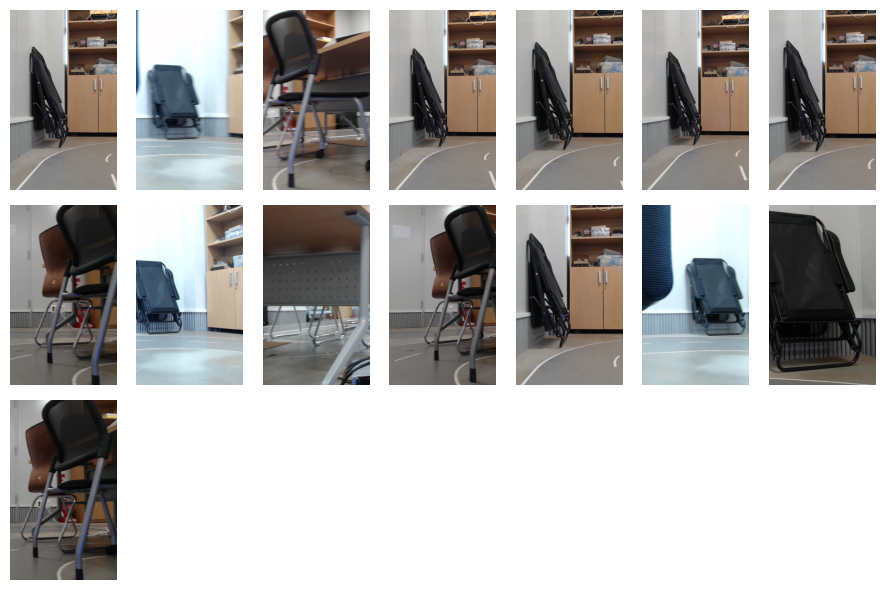

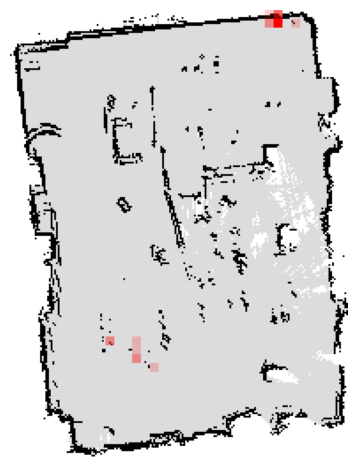

In [4]:
os.chdir(notebook_dir)
os.chdir('./exp0610_ViT-B-16-SigLIP_3_copy')
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)
with open('features_ind.pkl', 'rb') as file:
    features_ind = pickle.load(file)
with open('text_features.pkl', 'rb') as file:
    text_features = pickle.load(file)
print(text_features['list'])
text_list = text_features['list']
for text in text_list:
    print(f'{text}')
    text_feature = text_features[text]
    conf = get_conf(features, features_ind, text_feature, show_candidates=True, text=text)
    probability_map = probmap(conf, _map, map_data, 0.25, 'freq', show=True)
    plt.figure(text)
    plt.axis('off')
    plt.tight_layout()
    probability_map = np.flip(probability_map, 0)
    probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
    plt.imshow(probability_map)
    plt.savefig(f'{text}_prob.png')

In [43]:
os.chdir(notebook_dir)
from utils import CLIP
os.chdir('../')
clip = CLIP('ViT-B-16-SigLIP')

In [49]:
os.chdir(notebook_dir)
os.chdir('./exp0610_ViT-B-16-SigLIP_5')
import time
with open('features.pkl', 'rb') as file:
    features = pickle.load(file)
with open('features_ind.pkl', 'rb') as file:
    features_ind = pickle.load(file)
with open('text_features.pkl', 'rb') as file:
    text_features = pickle.load(file)
print(text_features['list'])
text_list = text_features['list']
cumtime = 0
for text in text_list:
    print(f'{text}')
    start = time.time()
    text_feature = clip.encode_text([text])
    conf = get_conf(features, features_ind, text_feature, show_candidates=False, text=text)
    conf_freq = dict(sorted(conf.items(), key=lambda item: item[1][1], reverse=True))
    try: goal = list(conf_freq.keys())[0]
    except: goal = 'None'
    flowtime = time.time()-start
    print(f'goal: {goal}, query time: {flowtime:.2f}s')
    cumtime += flowtime
avgtime = cumtime/len(text_list)
print(f'avgtime: {avgtime:.3f}')


['boxes', 'fire extinguisher', 'luggage', 'a single traffic cone', 'pile of traffic cones', 'trash bin', 'umbrella', 'trolley', 'chair', 'folded chair']
boxes
18 frames detected
[2023 2018 2008 2013 2101 2076 2081 1983 1988 2066 3138 2052 1919 2071
 2126 1731 2042 1924]
11 grid points are detected
conf: {(1.25, -8.0, 0.0): [0.014472015108194248, 9], (1.0, -8.0, 0.0): [0.014112545846106992, 6], (0.75, -8.25, 0.0): [0.0135288099656531, 7], (1.0, -8.25, 0.0): [0.013032594366371875, 11], (1.5, -8.5, 0.0): [0.013278610592429406, 4], (1.75, -8.75, 0.0): [0.01279633863820305, 5], (1.75, -8.5, 0.0): [0.012582848065441387, 6], (1.75, -8.25, 0.0): [0.011051360846288234, 2], (2.0, -8.5, 0.0): [0.011515395201633066, 1], (2.0, -8.25, 0.0): [0.011478398271968077, 2], (1.5, -8.75, 0.0): [0.010728920265740191, 1]}
goal: (1.0, -8.25, 0.0), query time: 0.31s
fire extinguisher
27 frames detected
[ 974  979  984 3660  933  938 3645  969 3640  964 3650  928 3655  959
  943  989 3665 3364  923  913  708  90

ViT-B-16-SigLIP
1352 / 9.7 / 0.149
2516 / 17.8 / 0.205
3018 / 21.2 / 0.215
4156 / 29.1 / 0.251
4900 / 34.2 / 0.278

ViT-B-32
1384 / 6.8 / 0.129
2480 / 11.8 / 0.166
3633 / 17.1 / 0.201
4704 / 22.1 / 0.256
5470 / 25.6 / 0.231

ViT-B-32-256
1346 / 6.6 / 0.123
2616 / 12.4 / 0.170
3787 / 17.7 / 0.206
4961 / 23.2 / 0.248
5205 / 24.3 / 0.276

ViT-L-14-quickgelu
1011 / 7.3MB / 0.127
1612 / 11.4MB / 0.175
2094 / 14.7MB / 0.196
2424 / 17.0MB / 0.201
2665 / 18.6MB / 0.225

In [6]:
os.chdir(notebook_dir)
from utils import CLIP
os.chdir('../')
clip = CLIP('ViT-B-16-SigLIP')
os.chdir(notebook_dir)
os.chdir('./exp0610_ViT-B-16-SigLIP_1')

c:\Users\Blu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Blu\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [7]:
from IPython.display import clear_output
while True:
    try:
        clear_output(wait=True)
        string = input('Enter text: ')
        if string == '': break
        print(f'{string}')
        text_feature = clip.encode_text([string])
        conf = get_conf(features, features_ind, text_feature, show_candidates=True, text=string)
        probability_map = probmap(conf, _map, map_data, 0.25, 'freq')
        plt.figure(string)
        plt.axis('off')
        plt.tight_layout()
        probability_map = np.flip(probability_map, 0)
        probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
        plt.imshow(probability_map)
        plt.show()
    except Exception as e:
        print(e)